In [1]:
pip install 'monai[all]' 

     |████████████████████████████████| 584 kB 8.3 MB/s 
     |████████████████████████████████| 316 kB 42.4 MB/s 
     |████████████████████████████████| 2.9 MB 39.4 MB/s 
     |████████████████████████████████| 221 kB 44.5 MB/s 
     |████████████████████████████████| 76 kB 2.6 MB/s 
     |████████████████████████████████| 50.1 MB 79 kB/s 
     |████████████████████████████████| 14.0 MB 43.6 MB/s 
     |████████████████████████████████| 36.3 MB 40 kB/s 
     |████████████████████████████████| 68.0 MB 64 kB/s 
     |████████████████████████████████| 14.4 MB 20.1 MB/s 
     |████████████████████████████████| 10.3 MB 14.0 MB/s 
  Created wheel for openslide-python: filename=openslide_python-1.1.2-cp37-cp37m-linux_x86_64.whl size=27709 sha256=ad28c104513646acb4d798442c9bfb5edac80cd1731c207e3878ecf852dda60e
  Stored in directory: /root/.cache/pip/wheels/6f/c3/97/980962653f9305314bfb6d93f80be5e21f13e206af66fc7ad3
Successfully built openslide-python
  Attempting uninstall: tqdm
    Found ex

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd drive/MyDrive/dynamic

/content/drive/MyDrive/dynamic


In [4]:
import echonet

In [5]:
import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.patches as mpatches
import monai

import numpy as np
import copy
import pandas as pd
import torch
import torchvision
import os
import cv2 as cv
import echonet

from torch.utils.data import DataLoader

from torch.autograd import Variable
from monai.data import Dataset, ArrayDataset
from PIL import Image
from monai.transforms import LoadImage,Resize,Compose,AddChannel,ToTensor
from skimage.transform import resize
from monai.networks.nets import UNet
from torch.nn.functional import interpolate, normalize
from monai.networks import one_hot
from monai.metrics import compute_meandice

In [6]:
image_size = [256,256]

In [7]:
directory_main = '/content/drive/MyDrive/Echocardiography_ML_Project_Summer_2021'
path = os.path.join(directory_main, "best_segmentation_model_fold_2.pth")
model = UNet(
    dimensions=2,
    in_channels=1,  
    out_channels=4,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,

)
model.load_state_dict(torch.load(path)) 
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

In [8]:
mean, std = echonet.utils.get_mean_and_std(echonet.datasets.Echo(split="train"))
tasks = ["LargeFrame", "SmallFrame", "LargeTrace", "SmallTrace","Filename","LargeIndex","SmallIndex"]
kwargs = {"target_type": tasks,
          "mean": mean,
          "std": std
          }
test_dataset = echonet.datasets.Echo(split="test",**kwargs)

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


In [9]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=1, 
                                               num_workers=4, 
                                               shuffle=False, 
                                               pin_memory=False, 
                                               drop_last=True)

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [10]:
class Camusize(object):
    def __init__(self, im_size, norm):
        self.im_size = im_size
        self.norm = norm
        
    def _norm(self, frames):
        # make 0-1, but in tensors:
        # https://discuss.pytorch.org/t/how-to-efficiently-normalize-a-batch-of-tensor-to-0-1/65122/4
        AA = frames.clone()
        AA = AA.view(frames.size(0), -1)
        AA -= AA.min(1, keepdim=True)[0]
        AA /= AA.max(1, keepdim=True)[0]
        AA = AA.view(frames.shape)
        #normalized = torch.nn.functional.normalize
        return AA
    
    def _rgb2gray(self, frames):
        # 0.2989 * R + 0.5870 * G + 0.1140 * B 
        # In torch tensors a bit tougher. I'll just do the mean...
        # return np.multiply(frame, np.array([.2989, .5870, .1140])[:, None, None]).sum(axis=0)
        return torch.mul(frames, torch.tensor([.2989, .5870, .1140])[None, :, None, None]).sum(1, keepdim=True)
#         return frames.mean(1, keepdim=True)
        
    '''
    Object call: Should take frame and trace batches and convert to
    CAMUS-acceptable images (in [0-1], and 256x256 single channel):
    frames is n x 3 x 112 x 112 tensor
    traces is n x 112 x 112 tensor
    '''
    def __call__(self, frames, traces):
        out_frames = self._norm(frames)
        out_frames = self._rgb2gray(out_frames)
        out_frames = interpolate(out_frames, size=self.im_size,mode='bilinear', align_corners=False)
        
        out_traces = interpolate(traces.unsqueeze(1), size=self.im_size,mode='nearest').squeeze()
        
        return out_frames*255.0, out_traces

In [11]:
camusized_frames_list = []
camusized_traces_list = []


camusizer = Camusize(im_size=image_size, norm=True)

for (_, (large_frame, small_frame, large_trace, small_trace, file_name,large_idx,small_idx)) in test_dataloader:
    frames = torch.cat((large_frame, small_frame), 0)
    traces = torch.cat((large_trace, small_trace), 0)
    
    camusized_frames, camusized_traces = camusizer(frames, traces)
    camusized_frames_list.append(camusized_frames)
    camusized_traces_list.append(camusized_traces)
    

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [12]:
camusized_reshaped_list_images = []
camusized_reshaped_list_labels = []

In [13]:
for i in range(len(camusized_frames_list)):
  small_image = camusized_frames_list[i][0,:,:,:]
  large_image = camusized_frames_list[i][1,:,:,:]

  small_label = camusized_traces_list[i][0,:,:]
  large_label = camusized_traces_list[i][1,:,:]

  camusized_reshaped_list_images.append(small_image)
  camusized_reshaped_list_images.append(large_image)

  camusized_reshaped_list_labels.append(small_label)
  camusized_reshaped_list_labels.append(large_label)

In [14]:
list_data_dict = [{}]*len(camusized_reshaped_list_images)

for i in range(len(camusized_reshaped_list_images)):
  img_label_dict = {'image':camusized_reshaped_list_images[i],'label':camusized_reshaped_list_labels[i]}

  list_data_dict[i] = img_label_dict

In [15]:
ds = Dataset(list_data_dict,None)
loader = DataLoader(ds,1,4)

In [16]:
metric_sum = 0.0
metric_count = 0

largest_metric = -1.0
smallest_metric = 110.00

i = 0

metric_arr = []

for data in loader:
  image = data["image"]
  labels = data["label"]

  plt.figure("check", (18, 6))

  plt.subplot(1,3,1)
  plt.imshow(image.squeeze())

  plt.subplot(1,3,2)
  plt.imshow(labels.squeeze())

  #print(output.shape,labels.shape)

  output = model(image)
  #print(output.shape,labels.shape)

  #output = torch.nn.Softmax(dim=1)(output)
  #print(output)
  #print(output.shape,labels.shape)

  output = torch.argmax(output,dim=1,keepdim=True)
  #print(output)

  #print(output.shape,labels.shape)

  output = one_hot(output,num_classes=4,dim=1)
  #print(output.shape,labels.shape)

  labels = torch.unsqueeze(labels,0)
  #print(output.shape,labels.shape)

  labels = one_hot(labels,num_classes=4,dim=1)
  #print(output.shape,labels.shape)

  value = compute_meandice(
    y_pred=output,
    y=labels,
    include_background=True,
  )


  metric_count += len(value)
  metric_sum += value[:,1,...].sum() 

  metric = metric_sum / metric_count
  print("metric = ", metric)
  metric_arr.append(metric)

  if metric < smallest_metric:
    smallest_metric = metric

  if largest_metric < metric:
    largest_metric = metric

  metric_sum = 0.0
  metric_count = 0

  plt.subplot(1,3,3)
  plt.imshow(output.squeeze()[1,:,:])

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [18]:
np.amin(metric_arr),np.amax(metric_arr)

(0.1486618, 0.9648861)

In [19]:
np.ptp(metric_arr)

0.81622434

In [20]:
np.percentile(metric_arr,0),np.percentile(metric_arr,25),np.percentile(metric_arr,50),np.percentile(metric_arr,75),np.percentile(metric_arr,100)

(0.148661807179451,
 0.7575071901082993,
 0.8369672000408173,
 0.8865889012813568,
 0.9648861289024353)

In [21]:
np.median(metric_arr),np.mean(metric_arr)

(0.83696723, 0.8061195)

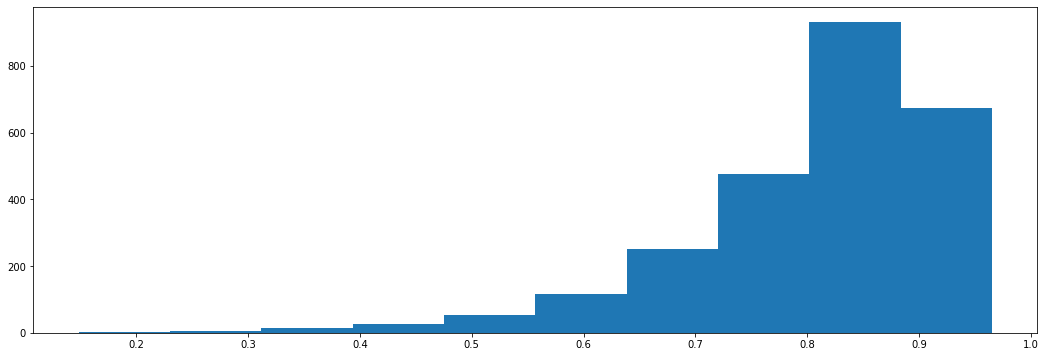

In [25]:
plt.figure("", (18, 6))
plt.hist(metric_arr,bins=10)
plt.show()

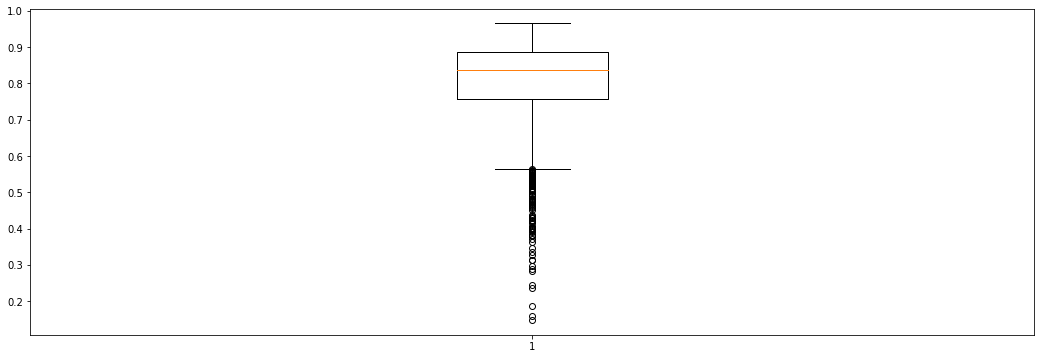

In [26]:
plt.figure("",(18, 6))
plt.boxplot(metric_arr)
plt.show()